In [3]:
from random import Random
import numpy as np
import pandas as pd
from tva.situation import Situation
from tva.schemes import Schemes, VotingScheme
from tva.voter import Voter

In [4]:
# Create the voting situation
situation = Situation(num_voters=4, num_candidates=4, seed=42)
display(situation.voters)

# Apply the voting scheme to the situation
schemes = Schemes()
winner1 = schemes.anti_plurality_voting(situation.preference_matrix)
winner2 = schemes.voting_for_two(situation.preference_matrix)
winnner3 = schemes.borda_voting(situation.preference_matrix)
print("Anti plurality:", winner1, ", Two voting:", winner2, ", Borda:", winnner3)



[Voter 0: ['A', 'C', 'D', 'B'],
 Voter 1: ['D', 'A', 'B', 'C'],
 Voter 2: ['C', 'A', 'D', 'B'],
 Voter 3: ['A', 'B', 'C', 'D']]

Anti plurality: A , Two voting: A , Borda: A


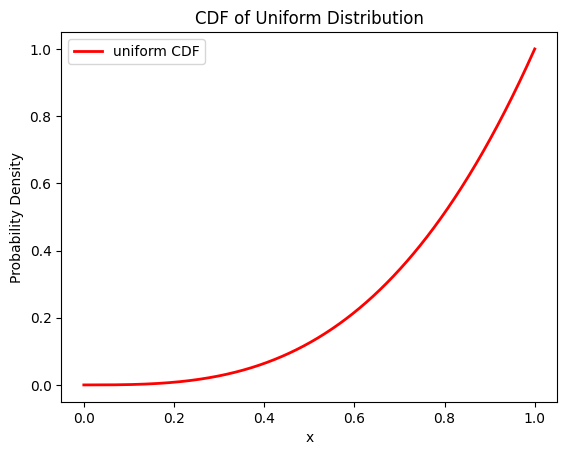

In [9]:
from scipy.stats import uniform

import matplotlib.pyplot as plt

# Define the parameters for the uniform distribution
a, b = 0, 1  # lower and upper bounds

# Generate x values
x = np.linspace(a, b, 1000)

# Calculate the PDF
cdf = uniform.cdf(x, loc=a, scale=b-a)

# Plot the PDF
plt.plot(x, cdf**3, 'r-', lw=2, label='uniform CDF')
plt.title('CDF of Uniform Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

In [3]:
class Strategies:
    def __init__(self, **kwargs):
        self.schemes = Schemes()
    
    def compromise(self, situation: Situation, voter_index: int, voting_scheme:VotingScheme):
        # schemes = Schemes(situation.preference_matrix)
        pass
    
    def bullet_vote(self, situation: Situation, voter_index: int, voting_scheme:VotingScheme):
        pass

    def bury(self, situation: Situation, voter_index: int, voting_scheme:VotingScheme):
        """Returns a new set of preferences for the voter to improve its happiness"""
        voter: Voter = situation.voters[voter_index]
        
        # Save the original happiness of this voter
        original_winner = self.schemes.apply_voting_scheme(voting_scheme, situation.preference_matrix)
        original_happiness = voter.happiness(original_winner)
        
        # Rank an alternative insincerely lower than another
        
        
    

SyntaxError: invalid syntax (2632773634.py, line 14)

In [9]:
situation.preference_matrix

[['A', 'C', 'D', 'B'],
 ['D', 'A', 'B', 'C'],
 ['C', 'A', 'D', 'B'],
 ['A', 'B', 'C', 'D']]

In [8]:
situation.voters[0].preferences

['A', 'C', 'D', 'B']